# 一、序列数据

 ## 自回归模型

对于时间序列数据（本文所指均为离散数据）而言，针对第t个时间点上的数据，人们可以利用前t-1个时间点的数据来进行预测，具体途径如下图所示：

$$ x_t ∼ P(x_t | x_{t−1}, . . . , x_1)$$

但是实际上，我们并不需要过长的序列数据来进行预测，也就引出了我们自回归模型的第一种策略,它的好处在于长度固定并且涉及到的数据较少：
$$ x_t ∼ P(x_t | x_{t−1}, . . . , x_\gamma) $$ 

第二种策略，我们可以保留之前的一些观测$h_{t-1}$以及$x_{t-2}$来对$x_{t-1}$进行预测，这种模型被称为隠变量自回归模型，如下图所示：

<img src="https://raw.githubusercontent.com/d2l-ai/d2l-zh/master/img/sequence-model.svg"> 

 ## 马尔科夫链

回想⼀下，在⾃回归模型的近似法中，我们使⽤$x_{t−1}$, . . . , $x_{t_\gamma}$ ⽽不是$x_{t−1}$, . . . , $x_1$来估计$x_t$。只要这种是近似精确的，我们就说序列满⾜⻢尔可夫条件（Markov condition）。

$$ P(x_{1}, . . . , x_{T} ) =\prod_{t=1}^n P({x_t|x_{t-1}})$$

当假设xt仅是离散值时，这样的模型特别棒，因为在这种情况下，使⽤动态规划可以沿着⻢尔可夫链精确地计算结果。

 ## 实践

在了解了上述统计⼯具后，让我们在实践中尝试⼀下！⾸先，我们⽣成⼀些数据：使⽤正弦函数和⼀些可加性噪声来⽣成序列数据，时间步为1, 2, . . . , 1000。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

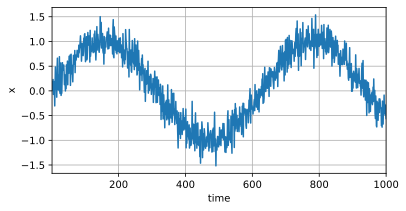

In [2]:
T = 1000 # 总共产⽣1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

接下来，我们将这个序列转换为模型的“特征－标签”（feature-label）对。基于嵌⼊维度τ，我们将数据映射为数据对$y_t = x_t 和x_t = [x_{t−τ} , . . . , x_{t−1}]$。你可能已经注意到，这⽐我们提供的数据样本少了τ个，因为我们没有⾜够的历史记录来描述前τ个数据样本。⼀个简单的解决办法是：如果拥有⾜够⻓的序列就丢弃这⼏项；另⼀个⽅法是⽤零填充序列。在这⾥，我们仅使⽤前600个“特征－标签”对进⾏训练。


In [3]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 600
# 只有前n_train个样本⽤于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
batch_size, is_train=True)

在这⾥，我们使⽤⼀个相当简单的架构训练模型：⼀个拥有两个全连接层的多层感知机，ReLU激活函数和平⽅损失。

In [7]:
# 初始化⽹络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
# ⼀个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net
# 平⽅损失。注意：MSELoss计算平⽅误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

现在，准备训练模型了。实现下⾯的训练代码的⽅式与前⾯⼏节（如 3.3节）中的循环训练基本相同。因此，我们不会深⼊探讨太多细节。

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
            f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
    
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.060543
epoch 2, loss: 0.057344
epoch 3, loss: 0.054249
epoch 4, loss: 0.052279
epoch 5, loss: 0.051779


由于训练损失很⼩，因此我们期望模型能有很好的⼯作效果。让我们看看这在实践中意味着什么。⾸先是检查模型预测下⼀个时间步的能⼒，也就是单步预测（one-step-ahead prediction）。

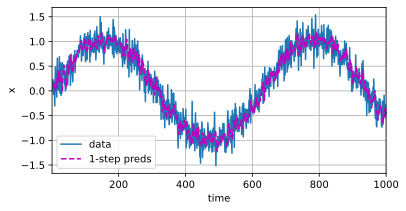

In [9]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
        'x', legend=['data', '1-step preds'], xlim=[1, 1000],
        figsize=(6, 3))

正如我们所料，单步预测效果不错。即使这些预测的时间步超过了600 + 4（n_train + tau），其结果看起
来仍然是可信的。然⽽有⼀个⼩问题：如果数据观察序列的时间步只到604，我们需要⼀步⼀步地向前迈进：


 $$  \hat x_{605} = f(x_{601}, x_{602}, x_{603}, x_{604}), \  $$
 $$  \hat x_{606} = f(x_{602}, x_{603}, x_{604}, \hat{x}_{605}), \$$

通常，对于直到xt的观测序列，其在时间步t + k处的预测输出$\hat x_{t+k} $称为k步预测（k-step-ahead-prediction）。由于我们的观察已经到了$x_{604}$，它的k步预测是$\hat x_{604+k}$。换句话说，我们必须使⽤我们⾃⼰的预测（⽽不是原始数据）来进⾏多步预测。让我们看看效果如何。

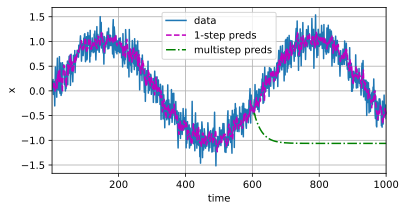

In [10]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
    [x.detach().numpy(), onestep_preds.detach().numpy(),
    multistep_preds[n_train + tau:].detach().numpy()], 'time',
    'x', legend=['data', '1-step preds', 'multistep preds'],
    xlim=[1, 1000], figsize=(6, 3))

为什么这个算法效果这么差呢？事实是由于错误的累积

基于k = 1, 4, 16, 64，通过对整个序列预测的计算，让我们更仔细地看⼀下k步预测的困难。

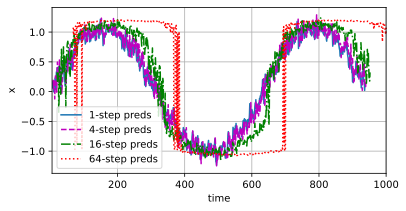

In [11]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i: i + T - tau - max_steps + 1]
    
# 列i（i>=tau）是来⾃（i-tau+1）步的预测，其时间步从（i）到（i+T-tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1: T - max_steps + i] for i in steps],
    [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time', 'x',
    legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000],
    figsize=(6, 3))


以上例⼦清楚地说明了当我们试图预测更远的未来时，预测的质量是如何变化的。虽然“4步预测”看起来仍然不错，但超过这个跨度的任何预测⼏乎都是⽆⽤的。

 # 二、文本预处理

对于序列数据处理问题，我们在 8.1节中评估了所需的统计⼯具和预测时⾯临的挑战。这样的数据存在许多
种形式，⽂本是最常⻅例⼦之⼀。例如，⼀篇⽂章可以被简单地看作是⼀串单词序列，甚⾄是⼀串字符序列。
本节中，我们将解析⽂本的常⻅预处理步骤。这些步骤通常包括：
1. 将⽂本作为字符串加载到内存中。
2. 将字符串拆分为词元（如单词和字符）。
3. 建⽴⼀个词表，将拆分的词元映射到数字索引。
4. 将⽂本转换为数字索引序列，⽅便模型操作。

In [9]:
import collections
import re
from d2l import torch as d2l

 ## 读取数据集

In [10]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine(): #@save
    """将时间机器数据集加载到⽂本⾏的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# ⽂本总⾏数: {len(lines)}')
print(lines[0])
print(lines[10])

# ⽂本总⾏数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


 ## 词元化

下⾯的tokenize函数将⽂本⾏列表（lines）作为输⼊，列表中的每个元素是⼀个⽂本序列（如⼀条⽂本⾏）。每个⽂本序列⼜被拆分成⼀个词元列表，词元（token）是⽂本的基本单位。最后，返回⼀个由词元列表组成的列表，其中的每个词元都是⼀个字符串（string）。

In [11]:
def tokenize(lines, token='word'): #@save
    """将⽂本⾏拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)
        
tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


词元的类型是字符串，⽽模型需要的输⼊是数字，因此这种类型不⽅便模型使⽤。现在，让我们构建⼀个字典，通常也叫做词表（vocabulary），⽤来将字符串类型的词元映射到从0开始的数字索引中。我们先将训练集中的所有⽂档合并在⼀起，对它们的唯⼀词元进⾏统计，得到的统计结果称之为语料（corpus）。然后根据每个唯⼀词元的出现频率，为其分配⼀个数字索引。很少出现的词元通常被移除，这可以降低复杂性。另外，语料库中不存在或已删除的任何词元都将映射到⼀个特定的未知词元“<unk>”。我们可以选择增加⼀个列表，⽤于保存那些被保留的词元，例如：填充词元（“<pad>”）；序列开始词元（“<bos>”）；序列结束词元
（“<eos>”）。


In [12]:
class Vocab: #@save
    """⽂本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
        reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
                
    def __len__(self):
        return len(self.idx_to_token)
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
    @property
    def unk(self): # 未知词元的索引为0
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs
def count_corpus(tokens): #@save
    """统计词元的频率"""
    # 这⾥的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成⼀个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

我们⾸先使⽤时光机器数据集作为语料库来构建词表，然后打印前⼏个⾼频词元及其索引。

In [13]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])


[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


现在，我们可以将每⼀条⽂本⾏转换成⼀个数字索引列表。

In [14]:
for i in [0, 10]:
    print('⽂本:', tokens[i])
    print('索引:', vocab[tokens[i]])

⽂本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
⽂本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


## 整合所有功能

在使⽤上述函数时，我们将所有功能打包到load_corpus_time_machine函数中，该函数返回corpus（词元索引列表）和vocab（时光机器语料库的词表）。我们在这⾥所做的改变是：
1. 为了简化后⾯章节中的训练，我们使⽤字符（⽽不是单词）实现⽂本词元化；
2. 时光机器数据集中的每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，还可能是⼀个单词，因此返回的corpus仅处理为单个列表，⽽不是使⽤多词元列表构成的⼀个列表。


In [15]:
def load_corpus_time_machine(max_tokens=-1): #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，
    # 所以将所有⽂本⾏展平到⼀个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

# 三、语言模型和数据集

假设⻓度为T的⽂本序列中的词元依次为$x_1, x_2, . . . , x_T$。于是，$x_t$（1 ≤ t ≤ T）可以被认为是⽂本序列在时间步t处的观测或标签。在给定这样的⽂本序列时，语⾔模型（language model）的⽬标是估计序列的联合概率

$$P(x_1, x_2, . . . , x_T ).$$ 

例如，包含了四个单词的⼀个⽂本序列的概率是：
$$P(deep, learning, is,fun) = P(deep)P(learning | deep)P(is | deep, learning)P(fun | deep, learning, is).$$

为了训练语⾔模型，我们需要计算单词的概率，以及给定前⾯⼏个单词后出现某个单词的条件概率。这些概率本质上就是语⾔模型的参数。
⼀种（稍稍不太精确的）⽅法是统计单词“deep”在数据集中的出现次数，然后将其除以整个语料库中的单词总数。这种⽅法效果不错，特别是对于频繁出现
的单词。接下来，我们可以尝试估计
$$\hat P(learning | deep) =\frac{n(deep, learning)}{n(deep)}$$

不幸的是，由于连续单词对“deep learning”的出现频率要低得多，所以估计这类单词正确的概率要困难得多。特别是对于⼀些不常⻅的单词组合，要想
找到⾜够的出现次数来获得准确的估计可能都不容易。

 ##  马尔可夫模型与n元语法

在讨论包含深度学习的解决⽅案之前，我们需要了解更多的概念和术语。回想⼀下我们在 8.1节中对⻢尔可夫模型的讨论，并且将其应⽤于语⾔建模。如果$P(x_{t+1} | x_t, . . . , x_1) = P(x_{t+1} | x_{t})$，则序列上的分布满⾜⼀阶⻢尔可夫性质。阶数越⾼，对应的依赖关系就越⻓。这种性质推导出了许多可以应⽤于序列建模的近似公式：

$$P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2)P(x_3)P(x_4),$$
$$P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 | x1)P(x_3 | x_2)P(x_4 | x_3),$$
$$P(x_1, x_2, x_3, x_4) = P(x_1)P(x_2 | x1)P(x_3 | x_1, x_2)P(x_4 | x_2, x_3).$$

通常，涉及⼀个、两个和三个变量的概率公式分别被称为“⼀元语法”（unigram）、“⼆元语法”（bigram）和“三元语法”（trigram）模型。下⾯，我们将学习如何去设计更好的模型。

## 自然语言统计

我们看看在真实数据上如果进⾏⾃然语⾔统计。根据 8.2节中介绍的时光机器数据集构建词表，并打印前10个最常⽤的（频率最⾼的）单词。


In [14]:
import random
import torch
from d2l import torch as d2l

In [13]:
tokens = d2l.tokenize(d2l.read_time_machine())
# 因为每个⽂本⾏不⼀定是⼀个句⼦或⼀个段落，因此我们把所有⽂本⾏拼接到⼀起
corpus = [token for line in tokens for token in line]
vocab = d2l.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，最流⾏的词看起来很⽆聊，这些词通常被称为停⽤词（stop words），因此可以被过滤掉。尽管如此，它们本⾝仍然是有意义的，我们仍然会在模型中使⽤它们。此外，还有个明显的问题是词频衰减
的速度相当地快。例如，最常⽤单词的词频对⽐，第10个还不到第1个的1/5。为了更好地理解，我们可以画出的词频图：

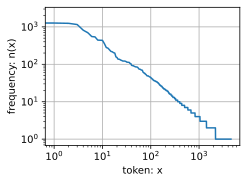

In [15]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)',
xscale='log', yscale='log')

通过此图我们可以发现：词频以⼀种明确的⽅式迅速衰减。将前⼏个单词作为例外消除后，剩余的所有单词⼤致遵循双对数坐标图上的⼀条直线。这意味着单词的频率满⾜⻬普夫定律（Zipf’s law），即第i个最常⽤
单词的频率ni为：

$$n_i=\frac{c}{i^\alpha}$$

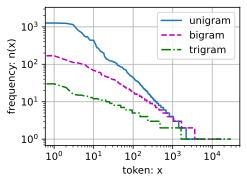

In [16]:
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = d2l.Vocab(bigram_tokens)

trigram_tokens = [triple for triple in zip(
corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = d2l.Vocab(trigram_tokens)

bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot([freqs, bigram_freqs, trigram_freqs], xlabel='token: x',
ylabel='frequency: n(x)', xscale='log', yscale='log',
legend=['unigram', 'bigram', 'trigram'])

这张图⾮常令⼈振奋！原因有很多：⾸先，除了⼀元语法词，单词序列似乎也遵循⻬普夫定律，尽管上面公式中的指数α更⼩（指数的⼤⼩受序列⻓度的影响）。其次，词表中n元组的数量并没有那么⼤，这说明语⾔中存在相当多的结构，这些结构给了我们应⽤模型的希望。

 ## 读取长序列数据

由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。在 8.1节中我们以⼀种相当特别的⽅式做到了这⼀点：当序列变得太⻓⽽不能被模型⼀次性全部处理时，我们可能希望拆分这样的序列⽅便模型读取。

在介绍该模型之前，我们看⼀下总体策略。假设我们将使⽤神经⽹络来训练语⾔模型，模型中的⽹络⼀次处理具有预定义⻓度（例如n个时间步）的⼀个⼩批量序列。现在的问题是如何随机⽣成⼀个⼩批量数据的特征和标签以供读取。

<img src="https://raw.githubusercontent.com/d2l-ai/d2l-zh/master/img/timemachine-5gram.svg"> 

因此，我们应该从 图8.3.1中选择哪⼀个呢？事实上，他们都⼀样的好。然⽽，如果我们只选择⼀个偏移量，那么⽤于训练⽹络的、所有可能的⼦序列的覆盖范围将是有限的。因此，我们可以从随机偏移量开始划分序列，以同时获得覆盖性（coverage）和随机性（randomness）。下⾯，我们将描述如何实现随机采样（randomsampling）和 顺序分区（sequential partitioning）策略。


### 随机采样

在随机采样中，每个样本都是在原始的⻓序列上任意捕获的⼦序列。在迭代过程中，来⾃两个相邻的、随机的、⼩批量中的⼦序列不⼀定在原始序列上相邻。对于语⾔建模，⽬标是基于到⽬前为⽌我们看到的词元来预测下⼀个词元，因此标签是移位了⼀个词元的原始序列。

下⾯的代码每次可以从数据中随机⽣成⼀个⼩批量。在这⾥，参数batch_size指定了每个⼩批量中⼦序列样本的数⽬，参数num_steps是每个⼦序列中预定义的时间步数。

In [12]:
def seq_data_iter_random(corpus, batch_size, num_steps): #@save
    """使⽤随机抽样⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始对序列进⾏分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # ⻓度为num_steps的⼦序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来⾃两个相邻的、随机的、⼩批量中的⼦序列不⼀定在原始序列上相邻
    random.shuffle(initial_indices)
    
    def data(pos):
        # 返回从pos位置开始的⻓度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这⾥，initial_indices包含⼦序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

下⾯我们⽣成⼀个从0到34的序列。假设批量⼤⼩为2，时间步数为5，这意味着可以⽣成 ⌊(35 − 1)/5⌋ = 6个“特征－标签”⼦序列对。如果设置⼩批量⼤⼩为2，我们只能得到3个⼩批量。

In [13]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[16, 17, 18, 19, 20],
        [26, 27, 28, 29, 30]]) 
Y: tensor([[17, 18, 19, 20, 21],
        [27, 28, 29, 30, 31]])
X:  tensor([[ 1,  2,  3,  4,  5],
        [21, 22, 23, 24, 25]]) 
Y: tensor([[ 2,  3,  4,  5,  6],
        [22, 23, 24, 25, 26]])
X:  tensor([[11, 12, 13, 14, 15],
        [ 6,  7,  8,  9, 10]]) 
Y: tensor([[12, 13, 14, 15, 16],
        [ 7,  8,  9, 10, 11]])


### 顺序分区

在迭代过程中，除了对原始序列可以随机抽样外，我们还可以保证两个相邻的⼩批量中的⼦序列在原始序列上也是相邻的。这种策略在基于⼩批量的迭代过程中保留了拆分的⼦序列的顺序，因此称为顺序分区。


In [14]:
def seq_data_iter_sequential(corpus, batch_size, num_steps): #@save
    """使⽤顺序分区⽣成⼀个⼩批量⼦序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y


基于相同的设置，通过顺序分区读取每个⼩批量的⼦序列的特征X和标签Y。通过将它们打印出来可以发现：迭代期间来⾃两个相邻的⼩批量中的⼦序列在原始序列中确实是相邻的。

In [15]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [17, 18, 19, 20, 21]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [18, 19, 20, 21, 22]])
X:  tensor([[ 5,  6,  7,  8,  9],
        [22, 23, 24, 25, 26]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [23, 24, 25, 26, 27]])
X:  tensor([[10, 11, 12, 13, 14],
        [27, 28, 29, 30, 31]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [28, 29, 30, 31, 32]])


现在，我们将上⾯的两个采样函数包装到⼀个类中，以便稍后可以将其⽤作数据迭代器。

In [16]:
class SeqDataLoader: #@save
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = d2l.seq_data_iter_random
        else:
            self.data_iter_fn = d2l.seq_data_iter_sequential
        self.corpus, self.vocab = d2l.load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps
    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)


最后，我们定义了⼀个函数load_data_time_machine，它同时返回数据迭代器和词表，因此可以与其他带有load_data前缀的函数（如 3.5节中定义的 d2l.load_data_fashion_mnist）类似地使⽤。

In [1]:
def load_data_time_machine(batch_size, num_steps, #@save
                            use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

# 四、循环神经网络 

上文中，我们介绍了n元语法模型，其中单词$x_t$在时间步t的条件概率仅取决于前面n-1个单词(例如"like deep learning",learning的条件概率取决于like deep的概率)。对于时间步t−(n−1)之前的单词，如果我们想将其可能产生的影响合并到$x_t$上，然⽽这样模型参数的数量也会随之呈指数增⻓，因为词表V需要存储$|V|^n$个数字，因此与其将$P(x_t | x_{t−1}, . . . , x_{t−n+1})$模型化，不如使用隐变量模型：

$$P(x_t | x_{t−1}, . . . , x_{t−n+1})\approx P(x_t | h_{t−1})$$

其中$h_{t−1}$是隐状态（hidden state），也称为隐藏变量（hidden variable），它存储了到时间步t−1的序列信息。通常，我们可以基于当前输⼊$x_t$和先前隐状态$h_{t−1}$来计算时间步t处的任何时间的隐状态：

$$h_t = f(x_t, h_{t−1})$$

对于上面的函数f，隐变量模型不是近似值。毕竟ht是可以仅仅存储到⽬前为⽌观察到的所有数据，然⽽这样的操作可能会使计算和存储的代价都变得昂贵。


循环神经⽹络（recurrent neural networks，RNNs）是具有隐状态的神经⽹络。

假设我们在时间步t有⼩批量输⼊$X_t ∈ R^{n×d}$。换⾔之，对于n个序列样本的⼩批量，Xt的每⼀⾏对应于来⾃该序列的时间步t处的⼀个样本。接下来，⽤$H_t ∈ R^{n×h}$ 表⽰时间步t的隐藏变量。$W_{xh}$是隐藏层权重参数∈$R^{d×h}$，与多层感知机不同的是，我们在这⾥保存了前⼀个时间步的隐藏变量$H_{t−1}$，并引⼊了⼀个新的权重参数$W_{hh}$∈$R^{h×h}$，来描述如何在当前时间步中使⽤前⼀个时间步的隐藏变量。具体地说，当前时间步隐藏变量由当前时间步的输⼊与前⼀个时间步的隐藏变量⼀起计算得出：

$$H_t = ϕ(X_t W_{xh} + H_{t−1}W_{hh} + b_h)$$

从相邻时间步的隐藏变量Ht和 Ht−1之间的关系可知，这些变量捕获并保留了序列直到其当前时间步的历史信息，就如当前时间步下神经⽹络的状
态或记忆，因此这样的隐藏变量被称为隐状态（hidden state）。由于在当前时间步中，隐状态使⽤的定义与前⼀个时间步中使⽤的定义相同，因此上面公式的计算是循环的（recurrent）。于是基于循环计算的隐状态神经⽹络被命名为 循环神经⽹络（recurrent neural network）。在循环神经⽹络中执⾏上面公式计算的层称为循环层（recurrent layer）。


对于时间步t，输出层的输出类似于多层感知机中的计算：

$$O_t = H_tW_{hq} + b_q$$

循环神经⽹络的参数包括隐藏层的权重$W_{xh}∈ R^{d×h}$, $W_{hh} ∈ R^{h×h}$和偏置$b_h∈ R^{1×h}$，以及输出层的权重$W_{hq}∈R^{h×q}$和偏置$b_q ∈ R^{1×q}$。值得⼀提的是，即使在不同的时间步，循环神经⽹络也总是使⽤这些模型参数。因此，循环神经⽹络的参数开销不会随着时间步的增加⽽增加。

下图展⽰了循环神经⽹络在三个相邻时间步的计算逻辑。在任意时间步t，隐状态的计算可以被视为：
1. 拼接当前时间步t的输⼊Xt和前⼀时间步t − 1的隐状态Ht−1；
2. 将拼接的结果送⼊带有激活函数ϕ的全连接层。全连接层的输出是当前时间步t的隐状态Ht。
在本例中，模型参数是$W_{xh}$和$W_{hh}$的拼接，以及$b_h$的偏置.当前时间步t的隐状态$H_t$将参与计算下⼀时间步t+1的隐状态$H_{t+1}$。⽽且Ht还将送⼊全连接输出层，⽤于计算当前时间步t的输出$O_t$。

 <img src= "https://raw.githubusercontent.com/d2l-ai/d2l-zh/master/img/rnn.svg"> 

## 基于循环神经⽹络的字符级语言模型

回想⼀下语言模型，我们的目标是根据过去的和当前的词元预测下⼀个词元，因此我们将原始序列移位⼀个词元作为标签。Bengio等⼈首先提出使⽤神经⽹络进⾏语⾔建模 [Bengio et al., 2003]。接下来，我们看⼀下如何使⽤循环神经⽹络来构建语⾔模型。设⼩批量⼤⼩为1，批量中的那个文本序列为“machine”。为了简化后续部分的训练，我们考虑使用字符级语⾔模型（character-level language model），将⽂本词元化为字符⽽不是单词。图8.4.2演⽰了如何通过基于字符级语⾔建模的循环神经⽹络，使用当前的和先前的字符预测下⼀个字符。输⼊序列和标签序列分别为“machin”和“achine”

 <img src= "https://raw.githubusercontent.com/d2l-ai/d2l-zh/master/img/rnn-train.svg"> 


在训练过程中，我们对每个时间步的输出层的输出进⾏softmax操作，然后利⽤交叉熵损失计算模型输出和标签之间的误差。由于隐藏层中隐状态的循环计算，图8.4.2中的第3个时间步的输出O3 由⽂本序列“m”、“a”和“c”确定。由于训练数据中这个⽂本序列的下⼀个字符是“h”，因此第3个时间步的损失将取决于下⼀个字符的概率分布，⽽下⼀个字符是基于特征序列“m”、“a”、“c”和这个时间步的标签“h”⽣成的。

## 困惑度

最后，让我们讨论如何度量语⾔模型的质量，这将在后续部分中⽤于评估基于循环神经⽹络的模型。⼀个好
的语⾔模型能够⽤⾼度准确的词元来预测我们接下来会看到什么。考虑⼀下由不同的语⾔模型给出的对“It
is raining …”（“…下⾬了”）的续写：
1. “It is raining outside”（外⾯下⾬了）
2. “It is raining banana tree”（⾹蕉树下⾬了）
3. “It is raining piouw;kcj pwepoiut”（piouw;kcj pwepoiut下⾬了）

就质量⽽⾔，例1显然是最合乎情理、在逻辑上最连贯的。虽然这个模型可能没有很准确地反映出后续词的语义，⽐如，“It is raining in San Francisco”（旧⾦⼭下⾬了）和“It is raining in winter”（冬天下⾬了）可能才是更完美的合理扩展，但该模型已经能够捕捉到跟在后⾯的是哪类单词。例2则要糟糕得多，因为其产⽣了⼀个⽆意义的续写。尽管如此，⾄少该模型已经学会了如何拼写单词，以及单词之间的某种程度的相关性。


最后，例3表明了训练不⾜的模型是⽆法正确地拟合数据的。我们可以通过计算序列的似然概率来度量模型的质量。然⽽这是⼀个难以理解、难以⽐较的数字。毕竟，较短的序列⽐较⻓的序列更有可能出现，因此评估模型产⽣托尔斯泰的巨著《战争与和平》的可能性不可避免地会⽐产⽣圣埃克苏佩⾥的中篇⼩说《⼩王⼦》可能性要⼩得多。⽽缺少的可能性值相当于平均数。在这⾥，信息论可以派上⽤场了。我们在引⼊softmax回归（3.4.7节）时定义了熵、惊异和交叉熵，并在信息论的在线附录104 中讨论了更多的信息论知识。如果想要压缩⽂本，我们可以根据当前词元集预测的下⼀个词元。⼀个更好的语⾔模型应该能让我们更准确地预测下⼀个词元。因此，它应该允许我们在压缩序列时花费更少的⽐特。所以我们可以通过⼀个序列中所有的n个词元的交叉熵损失的平均值来衡量：

$$\frac{1}{n} \sum_{t=1}^n -\log P(x_t \mid x_{t-1}, \ldots, x_1)$$

其中P由语⾔模型给出，$x_t$是在时间步t从该序列中观察到的实际词元。这使得不同⻓度的⽂档的性能具有了可⽐性。

困惑度的最好的理解是“下⼀个词元的实际选择数的调和平均数”。我们看看⼀些案例：

• 在最好的情况下，模型总是完美地估计标签词元的概率为1。在这种情况下，模型的困惑度为1。

• 在最坏的情况下，模型总是预测标签词元的概率为0。在这种情况下，困惑度是正⽆穷⼤。

• 在基线上，该模型的预测是词表的所有可⽤词元上的均匀分布。在这种情况下，困惑度等于词表中唯⼀词元的数量。

事实上，如果我们在没有任何压缩的情况下存储序列，这将是我们能做的最好的编码⽅式。因此，这种⽅式提供了⼀个重要的上限，⽽任何实际模型都必须超越这个上限。在接下来的⼩节中，我们将基于循环神经⽹络实现字符级语⾔模型，并使⽤困惑度来评估这样的模型。

## 循环神经网络的从零实现

In [24]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [25]:
batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

### 独热编码

回想⼀下，在train_iter中，每个词元都表⽰为⼀个数字索引，将这些索引直接输⼊神经⽹络可能会使
学习变得困难。我们通常将每个词元表⽰为更具表现⼒的特征向量。最简单的表⽰称为独热编码（one-hot
encoding），它在 3.4.1节中介绍过。

简⾔之，将每个索引映射为相互不同的单位向量：假设词表中不同词元的数⽬为N（即len(vocab)），词元
索引的范围为0到N − 1。如果词元的索引是整数i，那么我们将创建⼀个⻓度为N的全0向量，并将第i处的元
素设置为1。此向量是原始词元的⼀个独热向量。索引为0和2的独热向量如下所⽰：

In [26]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

我们每次采样的⼩批量数据形状是⼆维张量：（批量⼤⼩，时间步数）。one_hot函数将这样⼀个⼩批量数据转换成三维张量，张量的最后⼀个维度等于词表⼤⼩（len(vocab)）。我们经常转换输⼊的维度，以便获得形状为（时间步数，批量⼤⼩，词表⼤⼩）的输出。这将使我们能够更⽅便地通过最外层的维度，⼀步⼀步地更新⼩批量数据的隐状态。

In [27]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

### 初始化模型参数

In [28]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size
    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
# 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
# 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
# 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

### 循环神经网络模型

为了定义循环神经⽹络模型，我们⾸先需要⼀个init_rnn_state函数在初始化时返回隐状态。这个函数的返回是⼀个张量，张量全⽤0填充，形状为（批量⼤⼩，隐藏单元数）。在后⾯的章节中我们将会遇到隐状态包含多个变量的情况，⽽使⽤元组可以更容易地处理些。

In [30]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

下⾯的rnn函数定义了如何在⼀个时间步内计算隐状态和输出。循环神经⽹络模型通过inputs最外层的维度实现循环，以便逐时间步更新⼩批量数据的隐状态H。此外，这⾥使⽤tanh函数作为激活函数。如 4.1节所述，当元素在实数上满⾜均匀分布时，tanh函数的平均值为0。


In [31]:
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量⼤⼩，词表⼤⼩)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量⼤⼩，词表⼤⼩)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)


定义了所有需要的函数之后，接下来我们创建⼀个类来包装这些函数，并存储从零始实现的循环神经⽹络模型的参数。

In [32]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经⽹络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
            get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

让我们检查输出是否具有正确的形状。例如，隐状态的维数是否保持不变。

In [33]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                    init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())
Y, new_state = net(X.to(d2l.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

我们可以看到输出形状是（时间步数×批量⼤⼩，词表⼤⼩），⽽隐状态形状保持不变，即（批量⼤⼩，隐藏单元数）。

### 预测


让我们⾸先定义预测函数来⽣成prefix之后的新字符，其中的prefix是⼀个⽤⼾提供的包含多个字符的字符串。在循环遍历prefix中的开始字符时，我们不断地将隐状态传递到下⼀个时间步，但是不⽣成任何输出。这被称为预热（warm-up）期，因为在此期间模型会⾃我更新（例如，更新隐状态），但不会进⾏预测。预热期结束后，隐状态的值通常⽐刚开始的初始值更适合预测，从⽽预测字符并输出它们。


In [34]:
def predict_ch8(prefix, num_preds, net, vocab, device): #@save
    """在prefix后⾯⽣成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]: # 预热期
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds): # 预测num_preds步
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])


现在我们可以测试predict_ch8函数。我们将前缀指定为time traveller，并基于这个前缀⽣成10个后续字符。鉴于我们还没有训练⽹络，它会⽣成荒谬的预测结果。

In [35]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller abxzzzzzzz'

### 梯度裁剪

对于⻓度为T的序列，我们在迭代中计算这T个时间步上的梯度，将会在反向传播过程中产⽣⻓度为O(T)的矩阵乘法链。如 4.8节所述，当T较⼤时，它可能导致数值不稳定，例如可能导致梯度爆炸或梯度消失。因此，循环神经⽹络模型往往需要额外的⽅式来⽀持稳定训练。

⼀个流⾏的替代⽅案是通过将梯度g投影回给定半径（例如θ）的球来裁剪梯度g。如下式：
$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{|\mathbf{g}|}\right) \mathbf{g}.$$

通过这样做，我们知道梯度范数永远不会超过θ，并且更新后的梯度完全与g的原始⽅向对⻬。它还有⼀个值得拥有的副作⽤，即限制任何给定的⼩批量数据（以及其中任何给定的样本）对参数向量的影响，这赋予了模型⼀定程度的稳定性。梯度裁剪提供了⼀个快速修复梯度爆炸的⽅法，虽然它并不能完全解决问题，但它是众多有效的技术之⼀。

下⾯我们定义⼀个函数来裁剪模型的梯度，模型是从零开始实现的模型或由⾼级API构建的模型。我们在此计算了所有模型参数的梯度的范数。


In [36]:
def grad_clipping(net, theta): #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

### 训练

在训练模型之前，让我们定义⼀个函数在⼀个迭代周期内训练模型。它与我们训练3.6节模型的⽅式有三个
不同之处：
1. 序列数据的不同采样⽅法（随机采样和顺序分区）将导致隐状态初始化的差异。
2. 我们在更新模型参数之前裁剪梯度。这样的操作的⽬的是：即使训练过程中某个点上发⽣了梯度爆炸，
也能保证模型不会发散。
3. 我们⽤困惑度来评价模型。如 8.4.4节所述，这样的度量确保了不同⻓度的序列具有可⽐性。

In [37]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练⽹络⼀个迭代周期（定义⻅第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2) # 训练损失之和,词元数量
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # 在第⼀次迭代或使⽤随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调⽤了mean函数
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

循环神经⽹络模型的训练函数既⽀持从零开始实现，也可以使⽤⾼级API来实现。


In [38]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
            use_random_iter=False):
    """训练模型（定义⻅第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

现在，我们训练循环神经⽹络模型。因为我们在数据集中只使⽤了10000个词元，所以模型需要更多的迭代周期来更好地收敛。


困惑度 1.2, 67263.7 词元/秒 cuda:0
time travelleryou can show black is what is mean able to spegkat
travelleryou cav revell by the gore ovang ttre athere il th


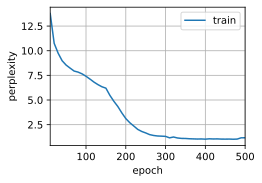

In [39]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

In [41]:
predict_ch8('time traveller ', 30, net, vocab, d2l.try_gpu())

'time traveller but nowimuld snighte by o jepp'